In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from dask.diagnostics import ProgressBar

In [3]:
import xarray as xr

In [4]:
base_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

In [5]:
list_files = [f'{base_url}.{year}.nc' for year in range(1979, 2021)]

In [6]:
list_files

['http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1979.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1980.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1981.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1982.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1983.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1984.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1985.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1986.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1987.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1988.nc',
 'http://w

In [7]:
dset = xr.open_mfdataset(list_files, parallel=True)

In [8]:
dset

<xarray.Dataset>
Dimensions:  (lon: 144, time: 61364, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1979-01-01 ... 2020-12-31T18:00:00
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(1460, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (1979)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 95/02/06 by Hoop (netCDF2.3)\nCo...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
dset.nbytes / 1e9

2.580725252

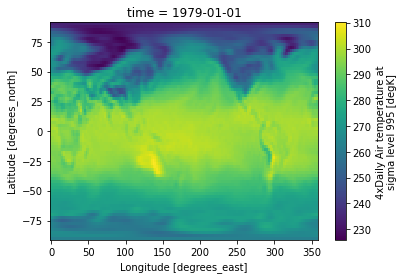

In [10]:
dset['air'].isel(time=0).plot()

In [11]:
dset = dset.chunk({'time':-1, 'lat':10, 'lon':10})

In [12]:
dset_ave = dset.mean('time')

In [13]:
with ProgressBar(): 
    dset_ave.compute()
    

[########################################] | 100% Completed | 10min 16.3s


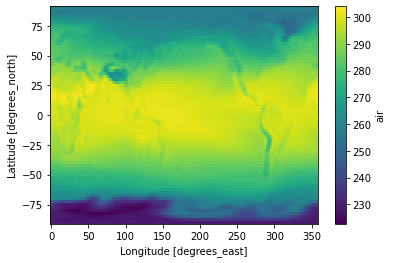

In [14]:
dset_ave['air'].plot()